# Reinforcement Learning Homework

Before you turn this notebook in, make sure everything runs as expected. First, **restart the kernel** (in the menu bar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menu bar, select Cell $\rightarrow$ Run All). You can also perform the two operations in one step (in the menu bar, select Kernel $\rightarrow$ Restart & Run All).

Make sure you fill in any place (or anywhere that you want in the code) that says `YOUR CODE HERE` or "YOUR ANSWER HERE", and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run). This is a reminder for you to complete all parts of the notebook. You can also send an incomplete notebook, but please remove all 'raise'-lines in any case.

You are not required to modify the code only where the line `YOUR CODE HERE` appears. In fact you can modify the given function and code as you want. Those are just reminders.

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your code, since this is the way we will do it before evaluating your notebook!

Fill in your name and ID number (matricola) below:

In [1]:
NAME = 'FILIPPO CONFORTO'
ID_number = int('2021856')

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# First Homework - Multi-Armed Bandits and Dynamic Programming

The present homework contains 2 exercises, one related to Multi-Armed Bandit problem and the other to Dynamic Programming.

- Delivery date: 2021/20/21

- Submission deadline: 2021/11/12 (23:59)

# Nonstationary Multi-Armed Bandits

The first part of the homework deals with the Multi Armed Bandit Problem.
In particular, the 10-armed testbed environment is exploited in order to understand what happens when dynamics are introduced in the arm rewards.
In order to complete the following exercise you will have to **modify** the 10-armed testbed environment in such a way that the mean values $q(a)$ of all the arms **start out equal** and then take **independent random walks**. This means that we will have:

$$ q_0(a) = 0, \qquad \forall a \in \mathcal{A}$$

$$q_t(a) = q_{t-1}(a) + w_{t-1}, \qquad \forall a \in \mathcal{A}, \qquad \textrm{where} \quad w_t \sim \mathcal{N}(0, \sigma^2)$$

Assume $\sigma = 0.1$.

Compare the performance of two different instances of the **Epsilon-Greedy algorithm**, one using **sample averages**, and the other using a **constant step size** $\alpha = 0.1$.
Plot the **average reward**, the **cumulative average reward**, and the **average percentage of optimal actions**: use $\epsilon=0.1$ and average over $500 \ \texttt{runs}$ for $5000 \ \texttt{steps}$.

##  IMPORTANT: Make sure that **before** the cell saying 'HERE ENDS THE FIRST EXERCISE' you have a variable called 'rewards' which is a numpy nd-array containing the average (over different runs) rewards of the two algorithms! To check this, you can run the assert statement in the cell: if it does not raise an error, you should be fine.

In [2]:
## Credits and imports

#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import seaborn as sns
from scipy.stats import poisson

For your convenience, the code discussed in the first "tutorial lesson" is reported below. Feel free to modify the code as you wish in order to achieve the required result.


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:58<00:00,  4.23it/s]


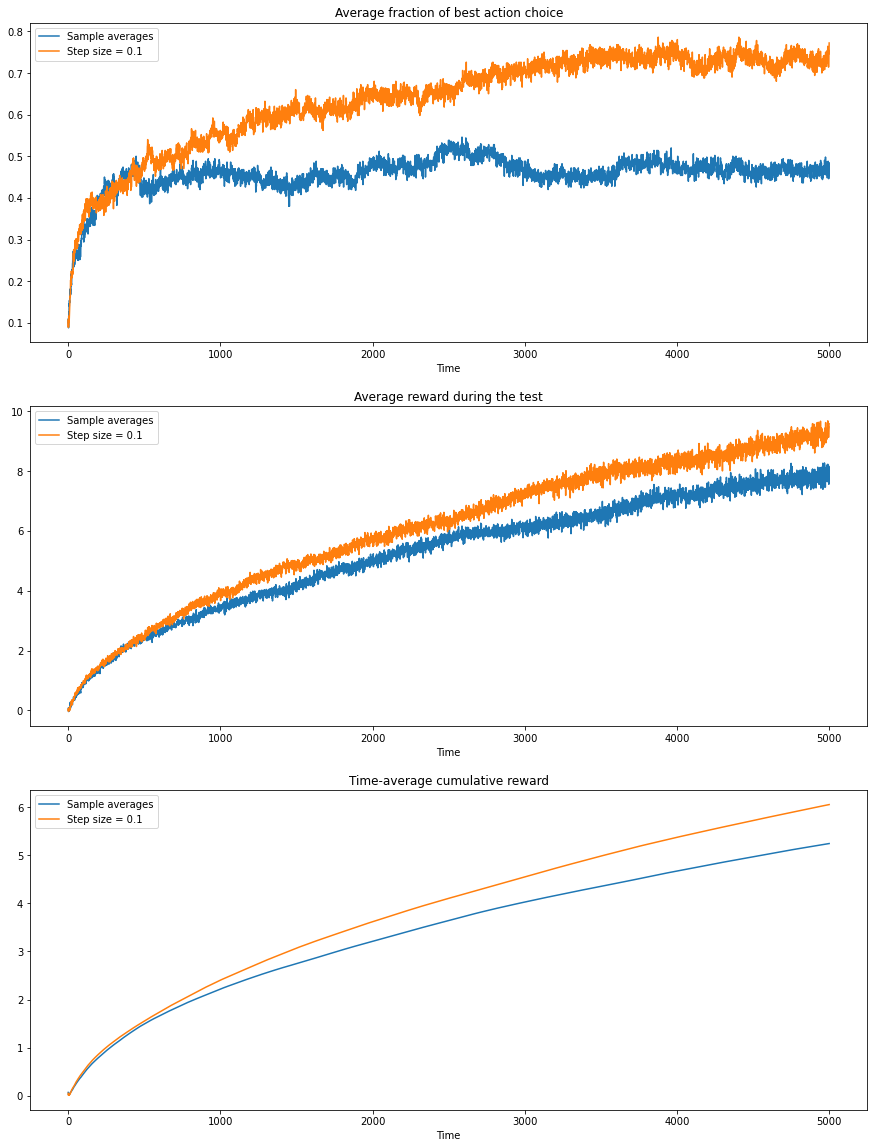

In [3]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        ###### is set as zero for the first iteration of the studied problem
        self.q_true = np.zeros(self.k)
        
        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices) 

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time
                            
        ###### The true value for q changes as a random walk with sigma = 0.1
        self.q_true += np.random.normal(0,0.1,self.k)
        ###### We need also to change the best action to collect correct data
        self.best_action = np.argmax(self.q_true)
        
        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    ###### Calculate cumulative average rewards
    cum_mean_rewards = rewards.cumsum(axis=2).mean(axis=1)/(np.arange(time)+1)
    
    return mean_best_action_counts, mean_rewards, cum_mean_rewards

# Recall you have to modify the environment above!
bandit_sample_averages = Bandit( epsilon=0.1, initial=0., sample_averages=True)
bandit_step_size = Bandit( epsilon=0.1, initial=0., step_size=0.1)

mean_best_action_counts, rewards, cum_mean_rewards = simulate(500,5000,[bandit_sample_averages,bandit_step_size])
# Code for the figures
fig,axes = plt.subplots(3, figsize = (15,20))

labels = ["Sample averages", "Step size = 0.1"]
titles = ["Average fraction of best action choice","Average reward during the test","Time-average cumulative reward"]

for i in range(2):
    axes[0].plot(mean_best_action_counts[i], label = labels[i])
    axes[1].plot(rewards[i], label = labels[i])
    axes[2].plot(cum_mean_rewards[i], label = labels[i])
    
for i,ax in enumerate(axes):
    ax.legend()
    ax.set_title(titles[i])
    ax.set_xlabel("Time")
    
plt.show()

In [4]:
# HERE ENDS THE FIRST EXERCISE
assert rewards.shape == (2, 5000)

Comment your results in the cell below. Which algorithm performed best? With respsect to which metric? Why? [~15 lines]

The new implementation of k-arm bandit seems to be a good testbench for different q-value estimation update techniques. The random walk used for q_true update allows the system to continuosly change the average reward for each arm, making very hard for our agent to understand what could be the best action to take for each timestep. We need so for our expected reward update a dynamic behaviour, in order to take into account the system unpredictability. 
<p><p>
From a theoretical point of view we expect the constant step size update to be the best choice, since it allows to compute our estimate update as a factor multiplied by the difference between our estimate and actual reward, instead of computing the average of all the experienced rewards. Indeed this last approach weights each contribution the same and does not take into account the importance of new rewards during the runtime.
<p><p>
From the results we can see how in general the probability to pick the right arm seems to improve only when we fix the step size, as expected. In the "sample average" case instead we are simply unable to follow the true average reward change and so we are choosing our new action according only to the total experienced rewards.
<p><p>
The other two metrics seems to highlight the expected theoretical behaviour. The average reward indeed is always higher for the constant step size setup, since it allows to take into account better the current state of average true rewards. Both the rewards also increase during the episode because of the behaviour of the random walk, which distribution in 1D is represented by a gaussian with variance proportional to the square root of the number of steps.
Finally the cumulative rewards seems also to reflect the previously defined behaviour, and again the fixed step size seems to be the best choice.

# Jack against the nationwide company

The second part of the homework consists of a modification of the Jack's Car Rental problem discussed during the second "Tutorial Lecture".
One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to **shuttle one car to the second location for free**, while each additional car costs the usual $2\$$. Moreover, the nationwide car rental company has changed its policy on parking spaces: for each location now Jack can only park up to 10 vehicles free of charge. **If more than 10 cars are kept overnight at a location, then an additional cost of $4\$$ must be incurred** to use a second parking lot (independent of how many cars are kept there). The car rental company charges Jack with the additional parking lots price first thing in the morning, **before any possible moving of cars**.
In order to fulfill the exercise requirements, you need to **modify and solve** the new instance of the Jack's car rental problem with a **Value Iteration** algorithm.
Generate a subplot with six cells as the one seen in the "Tutorial Lecture" with the figures of 5 policies at different iterations: #0, #7, #14, #21, and the last (optimal!) one. In the sixth box plot the optimal value-function.
Use $\texttt{constant}$_$\texttt{returned}$_$\texttt{cars}$ = **True**.

##  IMPORTANT: Make sure that **before** the cell saying 'HERE ENDS THE FIRST EXERCISE' you have a variable called 'policy' which is a numpy nd-array containing the optimal action for each pair of states, as in the notebook of the second "Tutorial Lecture"! To check this, you can run the assert statement in the cell: if it does not raise an error, you should be fine.

max value change 344.5067853702018
max value change 146.3593230770976
max value change 94.69450566785025
max value change 64.44706062331278
max value change 47.80507070324617
max value change 37.75789020332397
max value change 29.751746517165174
max value change 23.497526868688226
max value change 18.616711958333553
max value change 15.215400230148646
max value change 12.877974095617844
max value change 10.872656883618902
max value change 9.198161724261467
max value change 7.775853224233572
max value change 6.569123493366931
max value change 5.547580264963756
max value change 4.684002072307521
max value change 3.957184339969899
max value change 3.4007039870436984
max value change 2.9120898337968697
max value change 2.4903927643798056
max value change 2.128601708733754
max value change 1.8189165753133238
max value change 1.5541954652250638
max value change 1.3293516094798292
max value change 1.1371871199276598
max value change 0.9728062445207684
max value change 0.8321774715750507
max v

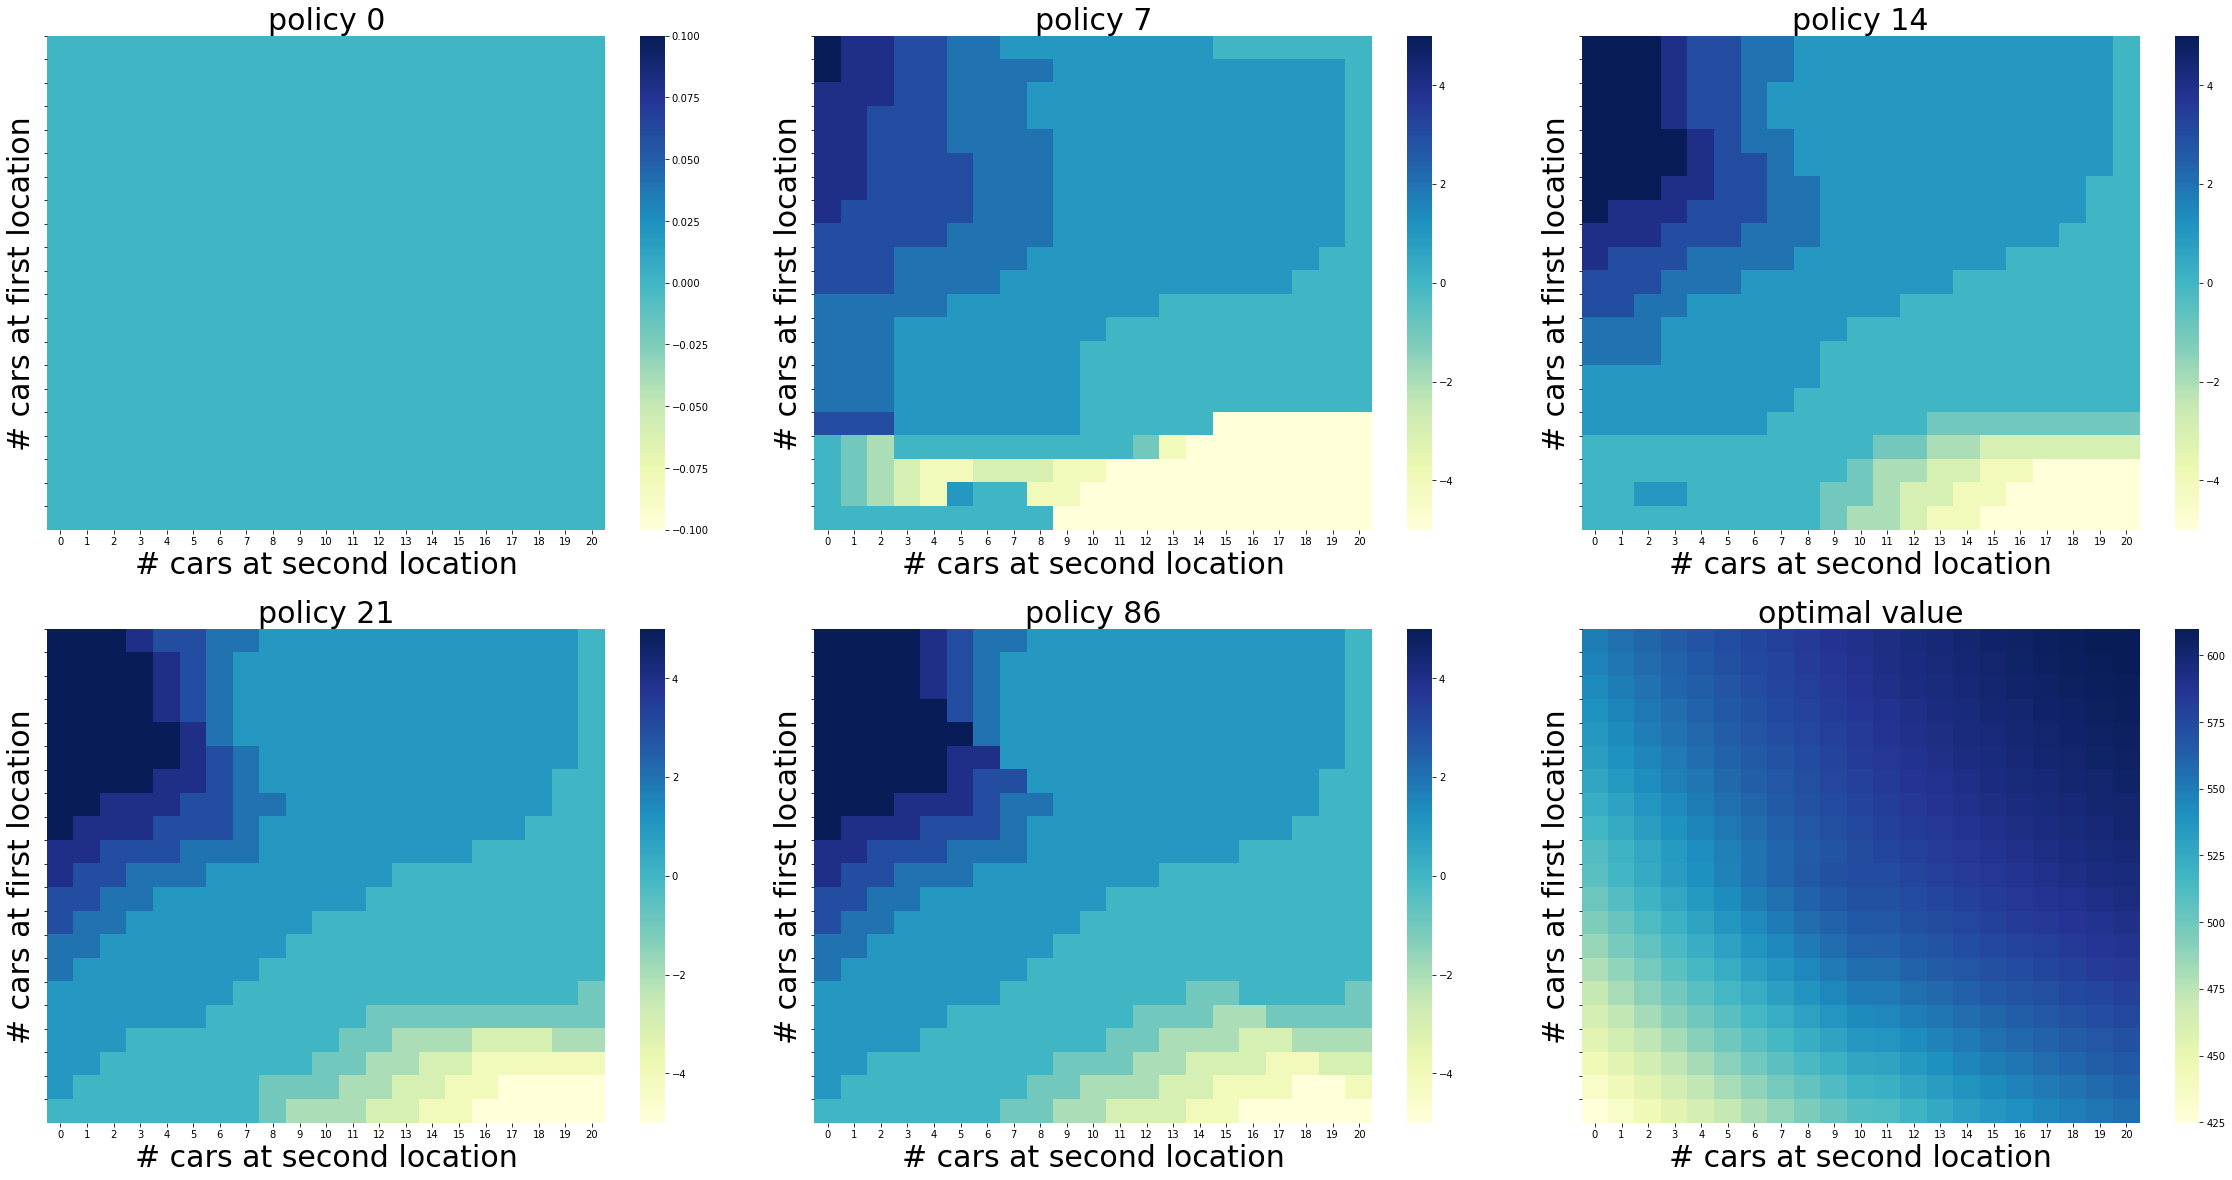

Wall time: 3min 36s


In [5]:
%%time
# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

# cost of keeping more than 10 cars at a single location - added for the exercise
KEEP_10_CAR_COST = 4

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# An upper bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UPPER_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()

def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initialize total return
    returns = 0.0
    
    ##### we have also to add the cost due to the eventual use of a secondary parking lot
    if (state[0]>10) or (state[1]>10):
        returns -= KEEP_10_CAR_COST
        
    # cost for moving cars
    ##### the first returns are calculated by reducing the cost associated to a single car transport 
    ##### from location 1 to location 2 since one of them can be transferred for free by a employee 
    if action >0:
        returns -= MOVE_CAR_COST * (action - 1) 
    else:
        returns -= MOVE_CAR_COST * abs(action) 
   
    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

# This is the parameter of the function in the original code
constant_returned_cars = True

value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

policy = np.zeros(value.shape, dtype=np.int64)

iterations = 0
theta = 1e-4 #### defining the threshold for which our update stops
delta = 0 #### defining the control value to check with theta

_, axes = plt.subplots(2, 3, figsize=(40, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

# Code for value iteration algorithm and figures
while True:
    #### Plotting value function for some iterations
    if iterations in [0,7,14,21]:
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[int(iterations/7)])
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('policy {}'.format(iterations), fontsize=30)
        
    old_value = value.copy()
    #### finding the maximum value of the return iterating over all the possible actions
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            action_returns = []
            for action in actions:
                # if it is a 'legal' action, i.e. I am not trying to move more cars than I have in that location
                if (0 <= action <= i) or (-j <= action <= 0):
                    action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                # fraud against the car rental company ---> lawyers, possible imprisonment, very low reward
                else:
                    action_returns.append(-np.inf)
            #### in-place update with value iteration algorithm
            new_state_value = np.max(action_returns)
            value[i, j] = new_state_value
            ##### updating the policy using greedily the action with the best return
            new_action = actions[np.argmax(action_returns)]
            policy[i, j] = new_action
            
    delta = abs(old_value - value).max() 
    print('max value change {}'.format(delta))
    iterations += 1
    
    if delta<theta:
        break
    
##### Plotting the converged policy
fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[4])
fig.set_ylabel('# cars at first location', fontsize=30)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=30)
fig.set_title('policy {}'.format(iterations), fontsize=30)

##### Plotting the converged value function
fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
fig.set_ylabel('# cars at first location', fontsize=30)
fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
fig.set_xlabel('# cars at second location', fontsize=30)
fig.set_title('optimal value', fontsize=30)
plt.show()

In [6]:
# HERE ENDS THE SECOND EXERCISE
assert policy.shape == (21, 21)

Comment your results in the cell below. Can you give an intuitive explanation for the optimal policy you found? [~15 lines]

The new environment is similar to the default one, with some differences, in particular we are allowing to move a car from the first to the second location for free, but also we are fixing a price for having more than 10 cars at a single location. These changes in rewards are computed by putting a penalty before any action takes place, if a second parking lot is used, and by changing the cost associated to car transport in the "expected_return" function. 
Another change was done by implementing a value iteration algorithm to evaluate the state value function. Indeed, we are not using anymore a policy iteration function, and so following the current policy, but we are evaluating the expected return using the Bellman Optimality Equation by considering only the action that gives the maximum expected return and updating accordingly the value function. In the same way the update is done from the policy side by choosing the action with the highest expected return for each state.
<p><p>
From the computational side this algorithm seems to take longer, probably because it has to find the best possible action for each iteration. These additional operations seems to have a large influence both on computation time and on iterations needed for convergence.
<p><p>
Compared to the default case, the produced graphs show a different shape both in the policy plot and the optimal value plot. The final policy seems to allow a larger use of car transport between the first and second location, since there is the possibility to move a single car without any cost. Also in general, as it can be observed in the policy plot, if we have a large number of cars at a single location the policy suggests to move them in order to reduce the penalty related to the second parking lot rental. Graphically this behaviour is reproduced by the dark blue and yellow zones becoming much larger compared to the ones seen in the default environment policy graph. 
<p><p>
The optimal value function graph also shows that for the central states the expected return is higher compared to the original environment. This is probably due to the reduced penalty in car movement associated to the employee that is moving a single car for free.